In [58]:
from agent_load_testing.use_case_generator import generate_garage_use_case
from rlway_cpagent.osrd_adapter import regulation_problem_from_schedule, schedule_from_solution
from rlway_cpagent.ortools_agent.ortools_solver import OrtoolsRegulationSolver
from rlway_cpagent.minizinc_agent.minizinc_solver import MinizincRegulationSolver
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from agent_load_testing.load_testing import matrix_load_testing, linear_load_testing

import nest_asyncio  
nest_asyncio.apply()

## Use case generation

In [2]:
problem = generate_garage_use_case(3, 5, 0.3)

## Solve

In [3]:
solver = OrtoolsRegulationSolver("ortools", 30)
solution = solver.solve(problem)
regulated_schedule = schedule_from_solution(solution)

## Viz Solution

<Axes: xlabel='Time'>

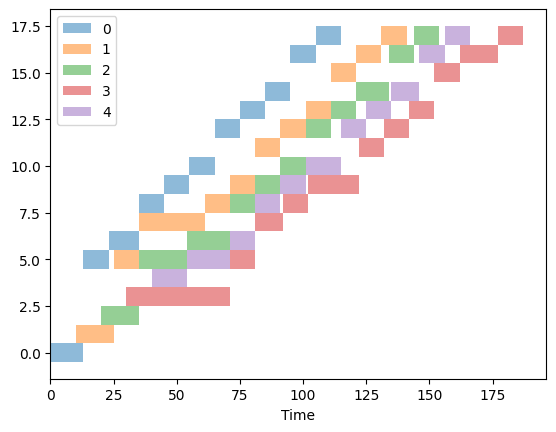

In [4]:
regulated_schedule.plot()

# Matrix Performance Testing

In [61]:
performances = matrix_load_testing(
    [OrtoolsRegulationSolver("ortools",10),
     MinizincRegulationSolver("minizinc", "gecode", 10)],
    generate_garage_use_case,
    ranges= {
        "nb_stations": range(1, 6),
        "nb_trains": range(1, 6),
        "delay_proba": [0.1]
    })

if not os.path.isfile('./performances.csv'):
   performances.to_csv("./performances.csv", header=True, index=False)
else:
   performances.to_csv("./performances.csv", mode='a', header=False, index=False)

1it [00:00,  3.12it/s]


### Ortools

In [11]:
df = performances.pivot(index='nb_stations', columns='nb_trains', values='ortools')
#print(df)
df = df.sort_index(ascending=False)
print(df)

nb_trains           1         2         3         4         5
nb_stations                                                  
5            0.003138  0.011015  0.012730  0.107301  0.122289
4            0.003208  0.008293  0.010433  0.089978  0.016686
3            0.002698  0.006390  0.010631  0.010450  0.309106
2            0.002495  0.003580  0.006258  0.013902  0.041826
1            0.002157  0.004219  0.005770  0.006090  0.020705


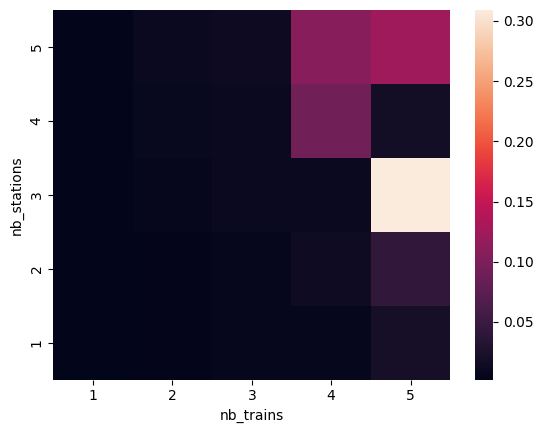

In [12]:
ax = sns.heatmap(df)
plt.show()

### Minizinc

In [13]:
df = performances.pivot(index='nb_stations', columns='nb_trains', values='minizinc')
#print(df)
df = df.sort_index(ascending=False)
print(df)

nb_trains           1         2          3          4          5
nb_stations                                                     
5            0.237803  0.323905  10.148976  10.156622  10.149003
4            0.254320  0.238466   0.249753  10.144396  10.149022
3            0.232199  0.639179   0.419538  10.149806  10.148585
2            0.234372  0.251190   5.370259  10.147903  10.152195
1            0.259734  0.248231   0.258176   0.450792  10.144518


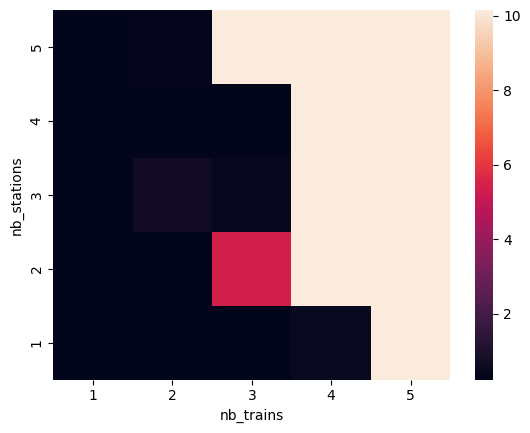

In [14]:
ax = sns.heatmap(df)
plt.show()

### Linear Performance Testing

In [50]:
NOMINAL_NB_TRAINS = 5
NOMINAL_NB_STATIONS = 2
NOMINAL_PROBA_DELAY = 0.1

In [51]:
linear_performances = linear_load_testing(
    [OrtoolsRegulationSolver("ortools",3),
     MinizincRegulationSolver("minizinc", "gecode", 3)],
    generate_garage_use_case,
    ranges= {
        "nb_stations": {
            "range": list(range(1, 5, 2)) + list(range(5, 20, 4)),
            "nominal": NOMINAL_NB_STATIONS
        },
        "nb_trains": {
            "range": list(range(1, 5, 2)) + list(range(5, 20, 4)),
            "nominal": NOMINAL_NB_TRAINS
        },
        "delay_proba": {
            "range": [NOMINAL_PROBA_DELAY],
            "nominal": NOMINAL_PROBA_DELAY
        }
    })

if not os.path.isfile('./performances.csv'):
   linear_performances.to_csv("./performances.csv", header=True, index=False)
else:
   linear_performances.to_csv("./performances.csv", mode='a', header=False, index=False)

### Nb_Stations impact

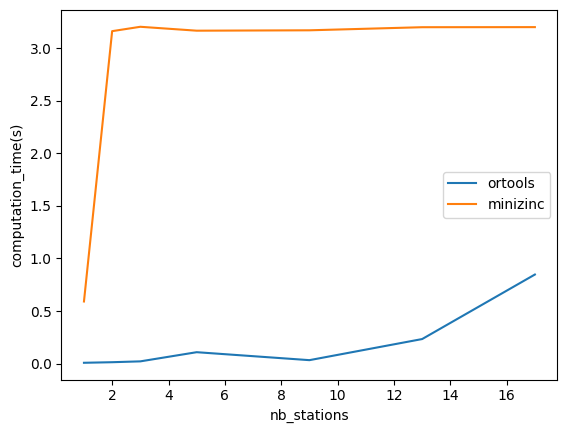

In [52]:
station_df = linear_performances[linear_performances['nb_trains'] == NOMINAL_NB_TRAINS]
station_df = station_df.drop_duplicates(subset=['nb_stations', 'nb_trains'])
station_df = station_df.sort_values(by="nb_stations", ascending=True)
plt.plot(station_df['nb_stations'], station_df['ortools'], label="ortools")
plt.plot(station_df['nb_stations'], station_df['minizinc'], label='minizinc')
plt.xlabel("nb_stations")
plt.ylabel("computation_time(s)")
plt.legend()

### Nb_Trains impact

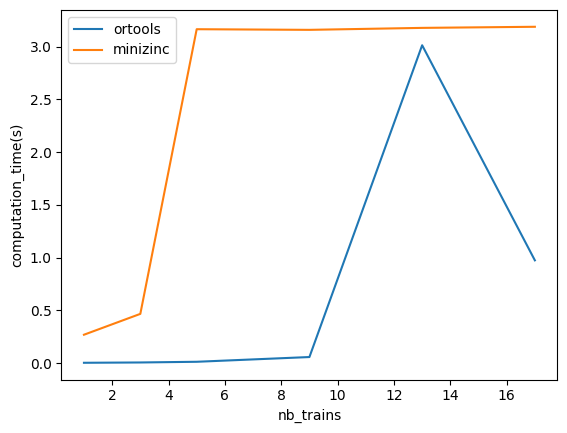

In [53]:
train_df = linear_performances[linear_performances['nb_stations'] == NOMINAL_NB_STATIONS]
train_df = train_df.drop_duplicates(subset=['nb_stations', 'nb_trains'])
train_df = train_df.sort_values(by="nb_trains", ascending=True)
plt.plot(train_df['nb_trains'], train_df['ortools'], label="ortools")
plt.plot(train_df['nb_trains'], train_df['minizinc'], label="minizinc")
plt.xlabel("nb_trains")
plt.ylabel("computation_time(s)")
plt.legend()

,nb_stations,nb_trains,ortools,minizinc
0,1,5,0.007322,1.309160
1,3,5,0.090795,3.170480
2,5,5,0.031189,3.165275
3,9,5,0.197654,3.164933
4,13,5,0.951690,3.166860
5,17,5,2.603911,3.176237
6,2,1,0.003842,0.242826
7,2,3,0.005634,3.148946
8,2,5,0.088887,3.158399
9,2,9,0.254845,3.164377
